In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import plots
from true_params import true_params
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/wfarr/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Figure 1

Figure 1 shows the true parameters and also the inferred masses and distances for our data set.

/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


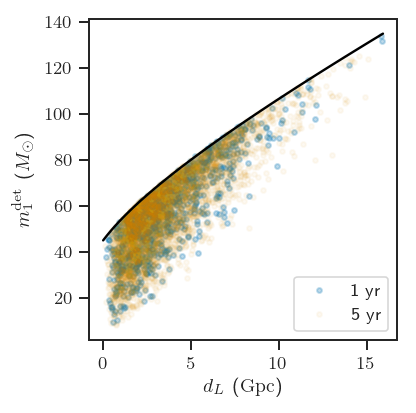

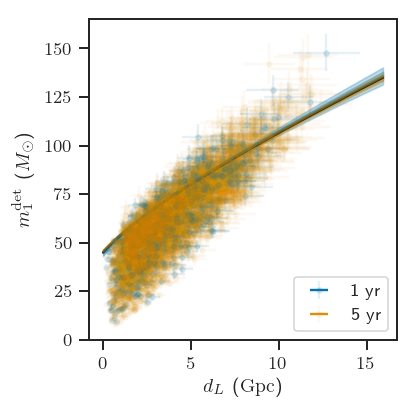

In [29]:
with h5py.File('observations.h5', 'r') as f:
    n1, _ = f.attrs['1yr']
    n1 = int(round(n1))
    m1s = array(f['m1s'])
    zs = array(f['zs'])
    
    m1det = array(f['posteriors/m1det'])
    dl = array(f['posteriors/dl'])
    
with plots.pub_plots(figsize=array(plots.figsize_pub)/2):
    figure()
    d = Planck15.luminosity_distance(zs).to(u.Gpc).value
    plot(d[:n1], m1s[:n1]*(1+zs[:n1]), '.', label='1 yr', color=sns.color_palette()[0], alpha=0.25)
    plot(d[n1:], m1s[n1:]*(1+zs[n1:]), '.', label='5 yr', alpha=0.05, color=sns.color_palette()[1])
    
    z = linspace(0, 2, 100)
    d = Planck15.luminosity_distance(z).to(u.Gpc).value
    
    mmz = true_params['MMax']*(1+z)
    
    plot(d, mmz, color='k')
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{det}$ ($M_\odot$)')
    
    l = legend(loc='lower right')
    for lh in l.legendHandles:
        lh.set_alpha(1)
    
    tight_layout()
    savefig('paper/plots/m1-dL-true.pdf')
    
    with h5py.File('paper/plots/m1-dL-true.h5', 'w') as f:
        one = f.create_group('1yr')
        five = f.create_group('5yr')
        
        one.create_dataset('dL', data=d[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det', data=m1s[:n1]*(1+zs[:n1]), compression='gzip', shuffle=True)
        
        five.create_dataset('dL', data=d[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det', data=m1s[n1:]*(1+zs[n1:]), compression='gzip', shuffle=True)
        
        f.create_dataset('dL', data=d, compression='gzip', shuffle=True)
        f.create_dataset('m1_turnoff', data=mmz, compression='gzip', shuffle=True)
        
    figure()
    
    dm = mean(dl, axis=1)
    ds = std(dl, axis=1)
    mm = mean(m1det, axis=1)
    ms = std(m1det, axis=1)
    
    errorbar(dm[:n1], mm[:n1], xerr=ds[:n1], yerr=ms[:n1], fmt='.', label='1 yr', color=sns.color_palette()[0], alpha=0.1)
    errorbar(dm[n1:], mm[n1:], xerr=ds[n1:], yerr=ms[n1:], fmt='.', label='5 yr', color=sns.color_palette()[1], alpha=0.05)
    
    plot(d, mmz, color='k')
    
    with h5py.File('population_1yr.h5', 'r') as f:
        H0 = array(f['H0']).flatten()
        MMax = array(f['MMax']).flatten()
        Om = array(f['Om']).flatten()
        w0 = array(f['w']).flatten()
        w_a = array(f['w_a']).flatten()
        
    z = linspace(0, 10, 250)
    mmzs1 = []
    for h, M, O, w, wa in zip(H0, MMax, Om, w0, w_a):
        c = cosmo.Flatw0waCDM(h, O, w, wa)
        dd = c.luminosity_distance(z).to(u.Gpc).value
        zs = interp1d(dd, z)(d)
        mmzs1.append(M*(1+zs))
    mmzs1 = array(mmzs1)
    
    plot(d, median(mmzs1, axis=0), color=sns.color_palette()[0], alpha=0.5)
    fill_between(d, percentile(mmzs1, 84, axis=0), percentile(mmzs1, 16, axis=0), alpha=0.25, color=sns.color_palette()[0])
    fill_between(d, percentile(mmzs1, 97.5, axis=0), percentile(mmzs1, 2.5, axis=0), alpha=0.25, color=sns.color_palette()[0])
    
    with h5py.File('population_5yr.h5', 'r') as f:
        H0 = array(f['H0']).flatten()
        MMax = array(f['MMax']).flatten()
        Om = array(f['Om']).flatten()
        w0 = array(f['w']).flatten()
        w_a = array(f['w_a']).flatten()
        
    z = linspace(0, 10, 250)
    mmzs5 = []
    for h, M, O, w, wa in zip(H0, MMax, Om, w0, w_a):
        c = cosmo.Flatw0waCDM(h, O, w, wa)
        dd = c.luminosity_distance(z).to(u.Gpc).value
        zs = interp1d(dd, z)(d)
        mmzs5.append(M*(1+zs))
    mmzs5 = array(mmzs5)
    
    plot(d, median(mmzs5, axis=0), alpha=0.5, color=sns.color_palette()[1])
    fill_between(d, percentile(mmzs5, 84, axis=0), percentile(mmzs5, 16, axis=0), alpha=0.25, color=sns.color_palette()[1])
    fill_between(d, percentile(mmzs5, 97.5, axis=0), percentile(mmzs5, 2.5, axis=0), alpha=0.25, color=sns.color_palette()[1])
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{det}$ ($M_\odot$)')
    
    l = legend(loc='lower right')
    for lh in l.legendHandles:
        lh.set_alpha(1)
        
    tight_layout()
    
    savefig('paper/plots/m1-dL-obs.pdf')
    
    with h5py.File('paper/plots/m1-dL-obs.h5', 'w') as f:
        one = f.create_group('1yr')
        five = f.create_group('5yr')
        
        one.create_dataset('dL', data=dm[:n1], compression='gzip', shuffle=True)
        one.create_dataset('dl_err', data=ds[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det', data=mm[:n1], compression='gzip', shuffle=True)
        one.create_dataset('m1det_err', data=ms[:n1], compression='gzip', shuffle=True)
        
        five.create_dataset('dL', data=dm[n1:], compression='gzip', shuffle=True)
        five.create_dataset('dl_err', data=ds[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det', data=mm[n1:], compression='gzip', shuffle=True)
        five.create_dataset('m1det_err', data=ms[n1:], compression='gzip', shuffle=True)
        
        f.create_dataset('dL', data=d, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff', data=mmz, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff_1yr', data=mmzs1, compression='gzip', shuffle=True)
        f.create_dataset('m1_cutoff_5yr', data=mmzs5, compression='gzip', shuffle=True)

In [ ]:
legend()

## Figure 2

Figure 2 shows the constraints we obtain on $H(z)$, with and without external cosmology.

Redshift at which 1-sigma fractional H(z) interval min of 0.041 is 0.73
Redshift at which 1-sigma fractional H(z) interval min of 0.019 is 0.72


/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


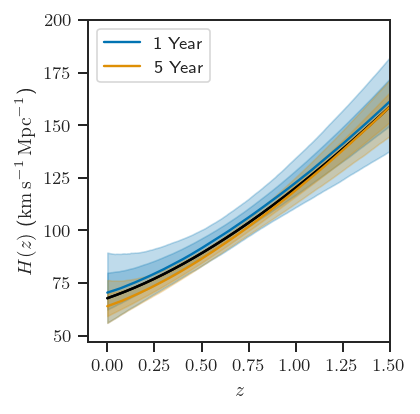

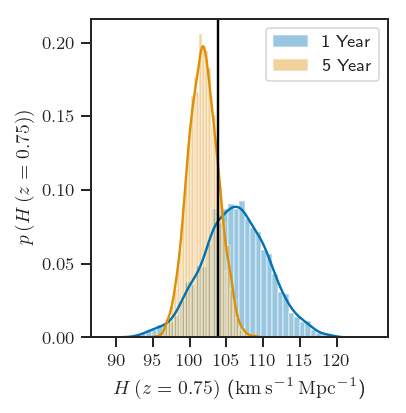

In [4]:
c = plots.load_chains('population_1yr.h5')
cc = plots.load_chains('population_5yr.h5', select_subset=[False, True, True, True])

with plots.pub_plots(figsize=array(plots.figsize_pub)/2):
    figure()
    
    zs, Hs1 = plots.Hz_plot(c, draw_tracks=False, label='1 Year')
    
    _, Hs5 = plots.Hz_plot(cc, color=sns.color_palette()[1], draw_tracks=False, label=r'5 Year')
    
    legend(loc='upper left')
    
    axis(xmax=1.5, ymax=200)
    
    xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
    
    tight_layout()
    savefig('paper/plots/Hz.pdf')
    
    with h5py.File('paper/plots/Hz.h5', 'w') as f:
        f.create_dataset('zs', data=zs, compression='gzip', shuffle=True)
        f.create_dataset('Hs-1yr', data=Hs1, compression='gzip', shuffle=True)
        f.create_dataset('Hs-5yr', data=Hs5, compression='gzip', shuffle=True)
        
    figure()
    i = argmin(abs(zs-0.75))
    
    H75_1 = array([cosmo.Flatw0waCDM(H0*u.km/u.s/u.Mpc, Om, w, w_a).efunc(0.75)*H0 for H0, Om, w, w_a in zip(c['H0'].flatten(), c['Om'].flatten(), c['w'].flatten(), c['w_a'].flatten())])
    H75_5 = array([cosmo.Flatw0waCDM(H0*u.km/u.s/u.Mpc, Om, w, w_a).efunc(0.75)*H0 for H0, Om, w, w_a in zip(cc['H0'].flatten(), cc['Om'].flatten(), cc['w'].flatten(), cc['w_a'].flatten())])
    
    sns.distplot(H75_1.flatten(), label='1 Year')
    sns.distplot(H75_5.flatten(), label='5 Year')
    
    xticks([90, 95, 100, 105, 110, 115, 120])
    
    
    xlabel(r'$H\left( z = 0.75 \right)$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H\left( z = 0.75 \right) \right)$')
    
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value*Planck15.efunc(0.75), color='k')
    
    legend(loc='best')
    
    tight_layout()
    savefig('paper/plots/H075.pdf')
    
    with h5py.File('paper/plots/H075.h5', 'w') as f:
        f.create_dataset('H075_1yr', data=H75_1.flatten(), compression='gzip', shuffle=True)
        f.create_dataset('H075_5yr', data=H75_5.flatten(), compression='gzip', shuffle=True)

## Figure 3

Figure 3 will show how the masses are corrected to find the redshift.

/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


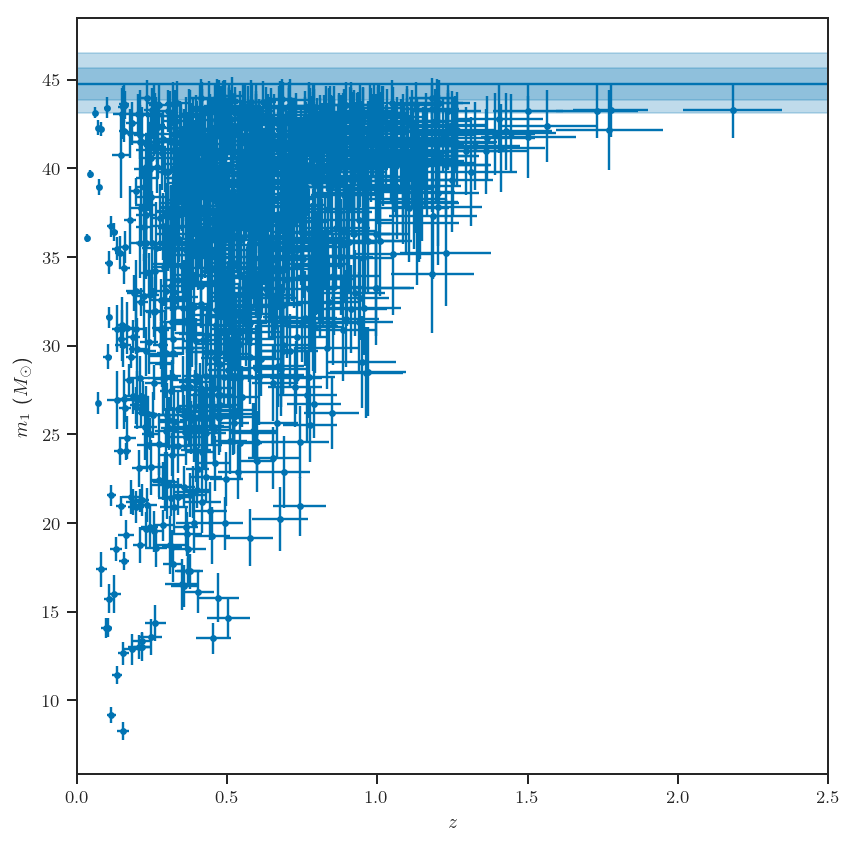

In [5]:
with plots.pub_plots():
    c = plots.load_chains('population_1yr.h5')
    plots.mass_correction_plot(c)
    axis(xmin=0, xmax=2.5)
    
    tight_layout()
    
    savefig('paper/plots/mass-correction.pdf')
    
    with h5py.File('paper/plots/mass-correction.h5', 'w') as f:
        f.attrs['MMax_median'] = median(c['MMax'])
        f.attrs['MMax_2.5'] = percentile(c['MMax'], 2.5)
        f.attrs['MMax_16'] = percentile(c['MMax'], 16)
        f.attrs['MMax_84'] = percentile(c['MMax'], 84)
        f.attrs['MMax_97.5'] = percentile(c['MMax'], 97.5)
        
        f.create_dataset('m1_mean', data=np.mean(c['m1s'], axis=(0,1)), compression='gzip', shuffle=True)
        f.create_dataset('m1_std', data=np.std(c['m1s'], axis=(0,1)), compression='gzip', shuffle=True)
        
        f.create_dataset('z_mean', data=np.mean(c['zs'], axis=(0,1)), compression='gzip', shuffle=True)
        f.create_dataset('z_std', data=np.std(c['zs'], axis=(0,1)), compression='gzip', shuffle=True)

## Figure 4

Figure 4 shows the constraints we obtain on pure dark-energy models with a fixed equation of state, incorporating other constraints on $H_0$ and $\Omega_M$.

We need the below call *before* the cell is evaluated to make the axes labels work out OK.

In [6]:
plt.rcParams['axes.unicode_minus'] = False

/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/wfarr/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


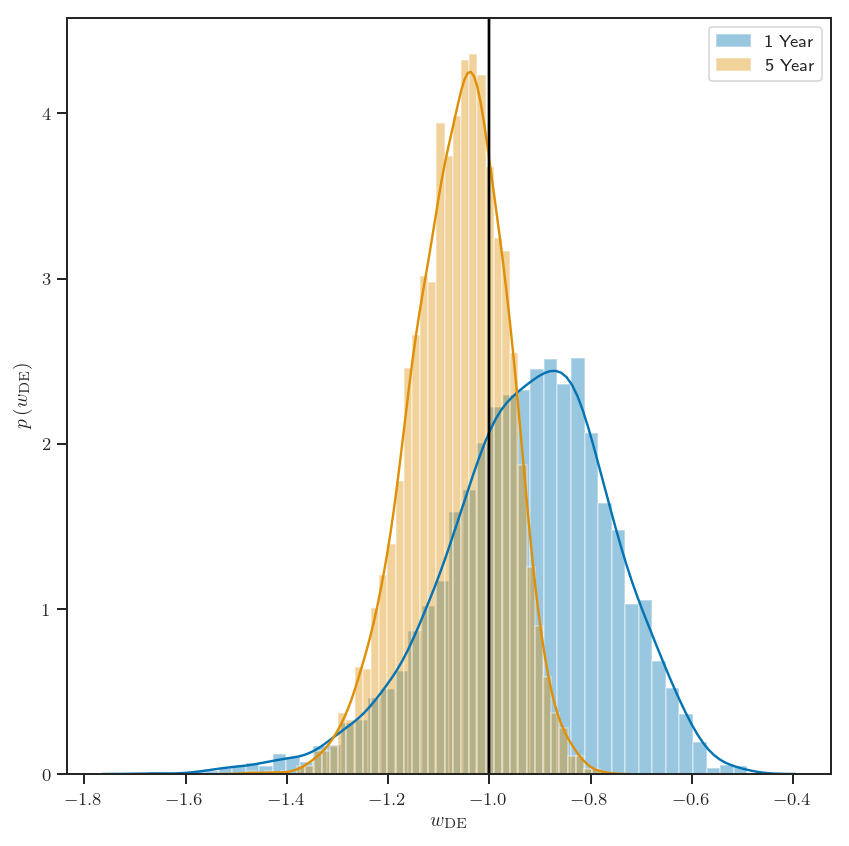

In [7]:
c = plots.load_chains('population_1yr_cosmo.h5')
cc = plots.load_chains('population_5yr_cosmo.h5')

with plots.pub_plots():    
    w1 = plots.pure_DE_w_plot(c, label='1 Year', notitle=True, nolines=True, color=sns.color_palette()[0])
    w5 = plots.pure_DE_w_plot(cc, label='5 Year', notitle=True, nolines=True, color=sns.color_palette()[1])

    legend(loc='best')
    
    tight_layout()
    savefig('paper/plots/wDE.pdf')
    
    with h5py.File('paper/plots/wDE.h5', 'w') as f:
        f.create_dataset('wDE_1yr', data=w1, compression='gzip', shuffle=True)
        f.create_dataset('wDE_5yr', data=w5, compression='gzip', shuffle=True)